# Анализ поведения пользователей в мобильном приложении для продажи продуктов питания

## Введение

В предстоящем проекте наша задача - проанализировать поведение пользователей мобильного приложения для продажи продуктов питания.
Мы проанализируем данные о событиях, которые совершают пользователи в приложении, а также исследуем результаты A/A/B-эксперимента, который провели маркетологи.
Наше исследование будет включать следующие шаги:
1. Мы изучим воронку продаж.
2. Узнаем, как пользователи доходят до покупки.
3. Проанализируем, сколько пользователей совершают покупку, а сколько отсеиваются на предыдущих шагах, и на каких шагах.
4. Исследуем результаты A/A/B-эксперимента.
5. Примем решение об остановке или продолжении эксперимента.
6. Сделаем выводы на основании проведенного исследования.

## Знакомство с данными

### Импорт нужных для работы библиотек

In [88]:
import pandas as pd
import math as mth
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px 
from plotly import graph_objects as go

Мы импортировали нужные для работы библиотеки

### Импорт датасетов

In [89]:
try:
    data = pd.read_csv('C:/Praktikum/food_app_project/logs_exp.csv',sep='\t', engine='python') 
except: 
      data = pd.read_csv('/datasets/logs_exp.csv',sep='\t', engine='python')

In [90]:
def data_first_look(data):
    print('Посмотрим на основную информацию:')
    print()
    data.info()
    print()
    print('Посмотрим на первые 10 строк таблицы:')
    display(data.head())
    print()
    print('Посмотрим характеристики таблицы:')
    display(data.describe())
    print()
    print('Количество дубликатов в данных равно', data.duplicated().sum())
    
data_first_look(data)    

Посмотрим на основную информацию:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Посмотрим на первые 10 строк таблицы:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



Посмотрим характеристики таблицы:


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000



Количество дубликатов в данных равно 413


In [91]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Мы импортировали файлы и посмотрели основную информацию о датасете. Датасет был "слеплен", то есть все данные оказались в одной колонке. Мы разделили его на 4 колонки с данными о событии, идентификатором пользователя, дате события и идентификатору группы в a/b-тесте.**

### Предобработка данных

In [92]:
data.rename({'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_date', 'ExpId':'group_id'}, axis=1, inplace = True)
# переименовали колонки в более читаемые

In [93]:
data['event_date'] = pd.to_datetime(data['event_date'], unit='s') # перевели дату из формата unix time
data['date_only'] = data['event_date'].dt.date
data['date_only'] = pd.to_datetime(data['date_only']) # создали отдельный столбец с датой
data['user_id'] = data['user_id'].astype(object)
data['group_id'] = data['group_id'].astype(object) # изменили формат данных

In [94]:
data.info()
data.head() # проверили, все ли сработало

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  object        
 2   event_date  244126 non-null  datetime64[ns]
 3   group_id    244126 non-null  object        
 4   date_only   244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.3+ MB


,event_name,user_id,event_date,group_id,date_only
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Переименовали колонки, поменяли формат данных, перевели формат timestamp в дату и время, а также создали отдельную колонку с датой.

In [95]:
data.duplicated().sum() #проверили на наличие дубликатов
data.drop_duplicates() # нашли 413 и удалили

,event_name,user_id,event_date,group_id,date_only
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [96]:
data['event_name'].value_counts() 

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

Мы посмотрели, какие уникальные значения есть в колонках с идентификатором группы и события и посчитали их количество. Пропусков в этих колонках нет.

In [97]:
data['group_id'].value_counts()

248    85747
246    80304
247    78075
Name: group_id, dtype: int64

**Группы распределены по количеству не совсем равномерно, в экспериментальной группе на 5-7 тысяч больше пользователей, чем в контрольных группах. Насколько это критично мы проверим в следующем разделе.
На этом предобработку данных можно считать законченной и переходить к проверке данных на корректность.**

## Проверка данных на корректность

В этом разделе мы проверим, корректны ли предоставленные нам данные, сможем ли мы с ними работать.

In [98]:
data.groupby('user_id', as_index=False)\
    .agg({'group_id':'nunique'})\
    .query("group_id>=2")\
    .shape

(0, 2)

Мы проверили, есть ли пользователи, попавшие в обе или все три группы - таких нет.

In [99]:
print('Общее количество событий в логе', data['event_name'].count())
print('Количество уникальных пользователей', data['user_id'].nunique())
print('Среднее количество событий на одного пользователя','{0:.2f}'.format(data['event_name'].count()/data['user_id'].nunique()))

Общее количество событий в логе 244126
Количество уникальных пользователей 7551
Среднее количество событий на одного пользователя 32.33


In [100]:
print('Минимальная дата в логе', data['date_only'].min()) 
print('Максимальная дата в логе', data['date_only'].max())

Минимальная дата в логе 2019-07-25 00:00:00
Максимальная дата в логе 2019-08-07 00:00:00


Мы посчитали среднее количество событий на пользователя и посмотрели за какой период у нас есть данные.

In [101]:
data.groupby('date_only').agg({'event_name':'count'})

,event_name
date_only,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,413
2019-07-31,2031
2019-08-01,36229
2019-08-02,35606


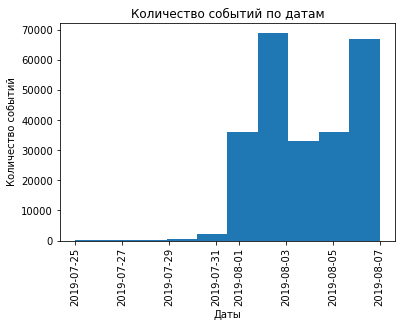

In [102]:
data['date_only'].hist(grid=False)
plt.xticks(rotation=90)
plt.title("Количество событий по датам")
plt.xlabel("Даты")
plt.ylabel("Количество событий")
plt.show()

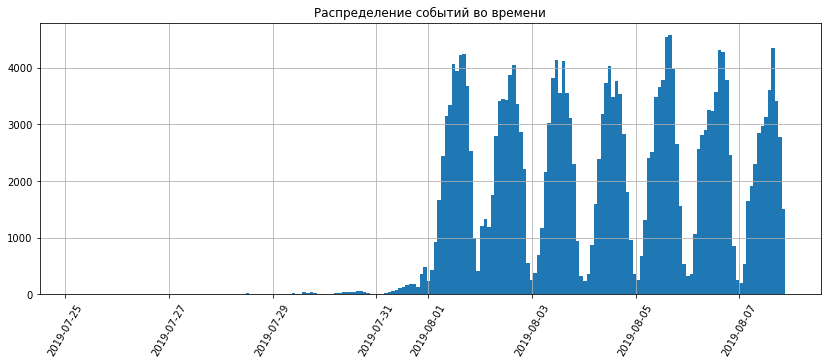

In [103]:
data['event_date'].hist(bins=200, figsize=(14, 5)).set_title('Распределение событий во времени')
plt.xticks(rotation=60);

In [104]:
data_date = data.query('date_only == "2019-07-31"')

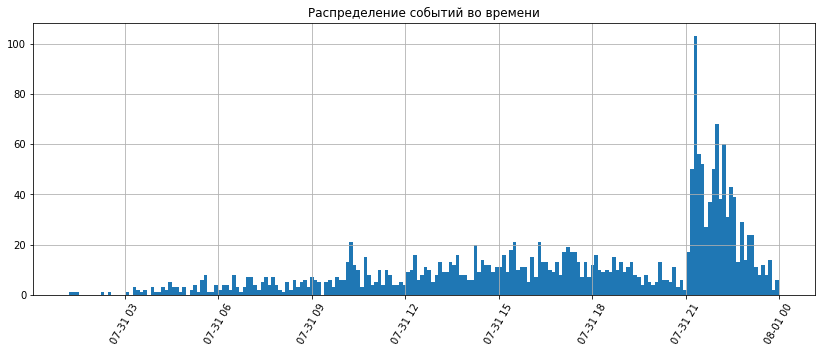

In [105]:
data_date['event_date'].hist(bins=200, figsize=(14, 5)).set_title('Распределение событий во времени')
plt.xticks(rotation=60);

Мы видим, что, несмотря на то, что данные у нас есть с 25 июля, значимое их количество появляется только с вечера - а точнее с 21 часа - 31 июля. То есть анализировать данные мы можем лишь за неделю.
Мы удалим "лишние" данные и посмотрим, как это повлияет на всю картину.

In [106]:
data_cleaned = data[(data['event_date'] >= '2019-07-25 21:00:00')] # убрали данные за ненужные даты
print('Общее количество событий в очищенном датасете', data_cleaned['event_name'].count()) 
print('Количество уникальных пользователей в очищенном датасете', data_cleaned['user_id'].nunique())
print('Среднее количество событий на одного пользователя в очищенном датасете','{0:.2f}'.format(data_cleaned['event_name'].count()/data_cleaned['user_id'].nunique()))

Общее количество событий в очищенном датасете 244117
Количество уникальных пользователей в очищенном датасете 7551
Среднее количество событий на одного пользователя в очищенном датасете 32.33


In [107]:
print('Процент пользователей, потерянных после ограничения даты', '{0:.3f}'.format(100 - (data_cleaned['user_id'].nunique()/data['user_id'].nunique()) * 100), '%')
print('Процент событий, потерянных после ограничения даты', '{0:.3f}'.format(100 - (data_cleaned['event_name'].count()/data['event_name'].count()) * 100), '%')

Процент пользователей, потерянных после ограничения даты 0.000 %
Процент событий, потерянных после ограничения даты 0.004 %


После удаления данных за дни, в которых событий было мало, мы не потеряли ни одного пользователя и всего лишь 0,4 % событий.

In [108]:
data_cleaned['group_id'].value_counts()

248    85743
246    80300
247    78074
Name: group_id, dtype: int64

После очистки датасеты у нас остались события из всех трех групп практически в тех же пропорциях, что и до неё.

**В процессе анализа данных на корректность мы выяснили, что, несмотря на то, что у нас есть данные о событиях за две недели, 80% событий приходится на вторую неделю. Так что мы очистили данные, оставив только события с 21:00 31.07.2017 до 07.08.2017. Мы проверили, что в этих данных остались все три группы пользователей и что они остались распределены в той же пропорции, что и были. В следующем разделе мы проанализируем воронку событий.**

## Анализ воронки событий

В этом разделе мы проанализируем воронку событий. Мы рассмотрим, какие события есть у нас в логе, в каком порядке они происходят, на каком этапе "отваливается" больше всего пользователей.

In [109]:
data_cleaned['event_name'].value_counts() # посчитали количество событий

MainScreenAppear           119201
OffersScreenAppear          46824
CartScreenAppear            42729
PaymentScreenSuccessful     34311
Tutorial                     1052
Name: event_name, dtype: int64

Всего в нашем дата сете пять видов событий: пользователь открыл приложение (случилось 119201 раз), пользователь перешел к коризне товаров (46824), пользователю предложили ввести данные карты (42729), пользователь произвел оплату (34311), пользователь прочитал инструкцию (1052).
Событие с инструкцией можно не добавлять в воронку событий, так как оно, судя по количеству, необязательное.

In [110]:
data_cleaned['user_id'].nunique() # нашли общее количество пользователей

7551

In [111]:
data_events = data_cleaned.groupby('event_name').agg({'user_id':'nunique',}).sort_values(by='user_id', ascending=False)
data_events.style

,user_id
event_name,
MainScreenAppear,7439
OffersScreenAppear,4613
CartScreenAppear,3749
PaymentScreenSuccessful,3547
Tutorial,847


Мы отсортировали события по количеству пользователей, их совершивших. Открыло приложение 7439 пользователей, перешли к корзине с товарами 4613 пользователей, к вводу данных карты 3749, оплатили покупку 3547 пользователей, посмотрели обучение 847 пользователей.

In [112]:
data_events['share'] = ((data_events['user_id'] / data_cleaned['user_id'].nunique()) * 100).round()
data_events

,user_id,share
event_name,,
MainScreenAppear,7439,99.0
OffersScreenAppear,4613,61.0
CartScreenAppear,3749,50.0
PaymentScreenSuccessful,3547,47.0
Tutorial,847,11.0


Мы подсчитали долю пользователей, совершивших каждое событие от количества пользователей в целом. Приложение запустило 99% пользователей, перешли к оплате 61%, начали вводить данные карты 50%, оплатили 47%, просмотрели обучение 11%.

In [113]:
fig = go.Figure(
    go.Funnel(
        y=[
            'Открыли приложение',
            'Перешли к оплате',
            'Начали вводить данные карты',
            'Оплатили',
        ],
        x=[7439, 4613, 3739, 3547],
    )
)
fig.show() 

**Как мы видим на графике, бОльшая часть пользователей отваливается во время перехода от открытия приложения к корзине с товарами. Всего 62% пользователей переходят между этими шагами. На дальнейших шагах переходы проходят менее заметно: от окна с оплатой к введению данных карты переходят 81,1% пользователей, а от ввода данных карты к окну успешной оплаты 94,9%.
Всего от открытия приложения до успешной оплаты доходят 47,7% пользователей.**

## Анализ A/A/B теста

В этой части проекта мы проанализируем проведенное A/A/B тестировние. Рассмотрим корректность разделения пользователей на группе, оценим результаты А/А теста, проверим уровень статистической значимости различий между контрольной и экспериментальной группами.

In [114]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244117 entries, 9 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244117 non-null  object        
 1   user_id     244117 non-null  object        
 2   event_date  244117 non-null  datetime64[ns]
 3   group_id    244117 non-null  object        
 4   date_only   244117 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 11.2+ MB


In [115]:
data_cleaned.groupby('group_id').agg({'user_id': 'nunique'}) #сгруппировали по количеству пользователей в каждой группе

,user_id
group_id,
246,2489
247,2520
248,2542


Мы посмотрели, сколько пользователей в каждой из групп. Пользователи распределены почти идеально равномерно, разница не превышает 31 пользователя, что не превышает 0,1% от всех пользователей.

In [116]:
data_group_A0 = data_cleaned.query('group_id == 246') # разбиваем датасет на три отдельных про группам, чтобы их сравнить

In [117]:
data_group_A1 = data_cleaned.query('group_id == 247')

In [118]:
data_group_B = data_cleaned.query('group_id == 248')

Сначала мы проверим гипотезу о равенстве долей для контрольных групп. Мы напишем функцию, чтобы проверить, является ли разница между событиями в контрольных группах статистически значимой.
Наша нулевая гипотеза в том, что изменение шрифта в приложении не повлияло на поведение пользователей. В нашем анализе мы посчитаем, является ли изменение поведения пользователей настолько значимым, что мы отвергнем нулевую гипотезу.
Наша альтернативная гипотеза, соответственно, в том, что изменение шрифта повлияло на пользовательское поведение в ту или иную сторону.

In [119]:
data_events_A0 = data_group_A0.groupby('event_name').agg({'user_id':'nunique',}).sort_values(by='user_id', ascending=False)
data_events_A0['share'] = (data_events_A0['user_id'] / data_group_A0['user_id'].nunique()*100).round()
data_events_A0.style # считаем количество пользоваетелей в каждой группе

,user_id,share
event_name,,
MainScreenAppear,2456,99.000000
OffersScreenAppear,1545,62.000000
CartScreenAppear,1270,51.000000
PaymentScreenSuccessful,1202,48.000000
Tutorial,279,11.000000


In [120]:
data_events_A1 = data_group_A1.groupby('event_name').agg({'user_id':'nunique',}).sort_values(by='user_id', ascending=False)
data_events_A1['share'] = (data_events_A1['user_id'] / data_group_A1['user_id'].nunique()*100).round()
data_events_A1.style

,user_id,share
event_name,,
MainScreenAppear,2482,98.000000
OffersScreenAppear,1530,61.000000
CartScreenAppear,1240,49.000000
PaymentScreenSuccessful,1160,46.000000
Tutorial,286,11.000000


Мы подсчитали количество пользователей, совершившее каждое действие в обеих группах.

In [121]:
print(data_group_A0['user_id'].nunique(), data_group_A1['user_id'].nunique()) 
# смотрим, сколько уникальных пользователей в каждой группе

2489 2520


Перед тем, как сравнивать данные, нужно определиться с уровнем значимости. Посколько у нас три сравнения, то вероятность получить ложноположительный результат - 14%. Поэтому мы будем использовать поправку Бонферрони, чтобы снизить вероятность ошибки второго рода.

In [122]:
def stat_difference(data_1, data_2, event): # пишем функцию, в которой будем считать статистическую значимость различий по каждому событию
    alpha = 0.05 
    bonferroni_alpha = alpha / 3
    leads_0 = data_1['user_id'].nunique()
    leads_1 = data_2['user_id'].nunique()
    event == event
    purchases_0 = data_1.query('event_name == @event')['user_id'].nunique()
    purchases_1 = data_2.query('event_name == @event')['user_id'].nunique()
    p1 = purchases_0/leads_0
    p2 = purchases_1/leads_1
    p_combined = (purchases_0 + purchases_1) / (leads_0 + leads_1)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads_0 + 1/leads_1))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', '{0:.3f}'.format(p_value))
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )
print(stat_difference(data_group_A0, data_group_A1, "MainScreenAppear"))
print(stat_difference(data_group_A0, data_group_A1, "OffersScreenAppear"))
print(stat_difference(data_group_A0, data_group_A1, "CartScreenAppear"))
print(stat_difference(data_group_A0, data_group_A1, "PaymentScreenSuccessful"))
print(stat_difference(data_group_A0, data_group_A1, "Tutorial"))

p-значение:  0.586
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.323
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.109
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.876
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


Исходя из сравнения между группами, мы видим, что в контрольных группах нет различий между количеством пользователей, совершивших события.
Мы можем сделать вывод, что разбиение на группы произошло корректно.
Дальше мы будем сравнивать первую контрольную группу с экспериментальной группой.

In [123]:
print(stat_difference(data_group_A0, data_group_B, "MainScreenAppear"))
print(stat_difference(data_group_A0, data_group_B, "OffersScreenAppear"))
print(stat_difference(data_group_A0, data_group_B, "CartScreenAppear"))
print(stat_difference(data_group_A0, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference(data_group_A0, data_group_B, "Tutorial"))

p-значение:  0.398
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.253
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.105
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.234
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.896
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


Между первой контрольной группой и экспериментальной различий тоже нет.

In [124]:
print(stat_difference(data_group_A1, data_group_B, "MainScreenAppear"))
print(stat_difference(data_group_A1, data_group_B, "OffersScreenAppear"))
print(stat_difference(data_group_A1, data_group_B, "CartScreenAppear"))
print(stat_difference(data_group_A1, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference(data_group_A1, data_group_B, "Tutorial"))

p-значение:  0.763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.741
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.773
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


Между второй контрольной группой и экспериментальной различий тоже нет.
Можно из интереса посмотреть, что будет, если убрать поправку Бонферрони:

In [125]:
def stat_difference_no_bonferroni(data_1, data_2, event): #пишем функцию, в которой будем считать статистическую значимость различий по каждому событию
    alpha = 0.05 
    leads_0 = data_1['user_id'].nunique()
    leads_1 = data_2['user_id'].nunique()
    event == event
    purchases_0 = data_1.query('event_name == @event')['user_id'].nunique()
    purchases_1 = data_2.query('event_name == @event')['user_id'].nunique()
    p1 = purchases_0/leads_0
    p2 = purchases_1/leads_1
    p_combined = (purchases_0 + purchases_1) / (leads_0 + leads_1)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads_0 + 1/leads_1))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', '{0:.3f}'.format(p_value))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

In [126]:
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "MainScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "OffersScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "CartScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "PaymentScreenSuccessful"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_A1, "Tutorial"))

p-значение:  0.586
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.323
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.109
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.876
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


In [127]:
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "MainScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "OffersScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "CartScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference_no_bonferroni(data_group_A0, data_group_B, "Tutorial"))

p-значение:  0.398
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.253
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.105
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.234
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.896
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


In [128]:
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "MainScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "OffersScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "CartScreenAppear"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "PaymentScreenSuccessful"))
print(stat_difference_no_bonferroni(data_group_A1, data_group_B, "Tutorial"))

p-значение:  0.763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.741
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None
p-значение:  0.773
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


Даже без поправки Бонферрони статистически значимой разницы между группами не наблюдается.

**На основании проведенного анализа A/A/B-теста можно сделать вывод, что статистически значимой разницы между тремя группами нет.**

## Выводы

Мы провели исследование поведения пользователей мобильного приложения для продажи продуктов питания.

В этом проекте перед нами стояло две задачи:
1. Узнать, как ведут себя пользователи мобильного приложения.
2. Проверить, влияет ли изменение шрифта в приложении на пользовательское поведение.

В процессе предобработки данных мы увидели, что фактически у нас есть данные не за 14 дней, а за 7, до этого событий было зарегистрировано минимальное количество. Так что мы удалили данные за первые 7 дней и дальше работали с оставшимися.

Мы изучили воронку продаж. 

В этом приложении воронка состоит из четырех событий: пользователь открывает приложение, переходит на страницу корзины товаров, потом на форму введения данных карты и, наконец, открывается окно об успешной оплате.

Значительная часть пользователей отваливается во время перехода от открытия приложения к корзине с товарами. Всего 62% пользователей переходят между этими шагами. 

Можно предположить, что дело в том, что пользователь не нашел нужный товар и не стал добавлять ничего в корзину. 

На дальнейших шагах переходы проходят менее заметно: от окна с оплатой к введению данных карты переходят 81,3% пользователей, а от ввода данных карты к окну успешной оплаты 95%.

Всего от открытия приложения до успешной оплаты доходят 47,7% пользователей

После этого мы провели статистический анализ и сравнили количество пользователей, совершающих то или иное событие в двух контрольных и одной экспериментальной группах.

Мы проверили, что разделение между всеми группами было произведено корректно. После этого мы провели сравнение долей пользователей, совершивших события. 
Мы не обнаружили статистически значимой разницы между группами ни в одном сравнении, используя поправку Бонферрони. 

Без поправки Бонферрони, впрочем, разницы между группами тоже нет.

**На основании проведенного анализа A/A/B-теста можно сделать вывод, что статистически значимой разницы между тремя группами нет.**

Тест можно остановить, так как почти во всех проверках разница между p-value и уровнем значимости довольно большая, так что ситуация вряд ли изменится.

**Мы делаем следующие выводы:**

**1. Нужно понять причину, почему пользователи теряются во время перехода от открытия приложения к корзине с товарами.**

**2. Смена шрифта в приложении никак не влияет на пользовательское поведение.**